In [3]:
!pip install -qqq torch lightning transformers datasets sentencepiece pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 61.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p .checkpoints/simplified

In [4]:
DRIVE_DATA_DIR="/content/drive/MyDrive/indic_unlearning/flores200_dataset"

In [5]:
!mkdir -p data/flores_test
!ln -sf {DRIVE_DATA_DIR}/valid.jsonl data/flores_test/valid.jsonl
!ln -sf {DRIVE_DATA_DIR}/test.jsonl data/flores_test/test.jsonl
!ln -sf {DRIVE_DATA_DIR}/forget-32.jsonl data/flores_test/forget-32.jsonl
!ln -sf {DRIVE_DATA_DIR}/retain-32-x2.jsonl data/flores_test/retain-32-x2.jsonl

In [1]:
import os
import json
import random
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive', force_remount=True)

# 2. Define the new, standard target paths and configuration
DRIVE_DATA_DIR = "/content/drive/MyDrive/indic_unlearning/flores_standard_data"
FORGET_LANGS = ["te", "bn", "hi"]
FORGET_NUM = 32
RETAIN_MULTIPLIER = 2

# 3. Ensure the directory exists
os.makedirs(DRIVE_DATA_DIR, exist_ok=True)
print(f"Target data directory created/verified: {DRIVE_DATA_DIR}")

# 4. Generate dummy FLORES-like data with correct structure
def generate_dummy_flores_data(size, langs):
    """Generates a list of dictionaries with correct language keys."""
    data = []
    dummy_text = "This is a dummy sentence for the language {lang_code}."
    for i in range(size):
        row = {}
        for lang in langs:
            # Correct FLORES structure where language code is the key
            row[lang] = dummy_text.format(lang_code=lang) + f" (id {i})"
        data.append(row)
    return data

def write_jsonl(data, filename):
    filepath = os.path.join(DRIVE_DATA_DIR, filename)
    with open(filepath, 'w', encoding='utf-8') as f:
        for entry in data:
            f.write(json.dumps(entry, ensure_ascii=False) + '\n')
    print(f"Generated and saved: {filename} (Size: {len(data)})")

# Files to generate: Forget (32), Retain (32x2=64), Test (100), Valid (100)
LANG_KEYS = FORGET_LANGS + ["en"] # Including a common language like English
write_jsonl(generate_dummy_flores_data(FORGET_NUM, LANG_KEYS), f"forget-{FORGET_NUM}.jsonl")
write_jsonl(generate_dummy_flores_data(FORGET_NUM * RETAIN_MULTIPLIER, LANG_KEYS), f"retain-{FORGET_NUM}-x{RETAIN_MULTIPLIER}.jsonl")
write_jsonl(generate_dummy_flores_data(100, LANG_KEYS), "test.jsonl")
write_jsonl(generate_dummy_flores_data(100, LANG_KEYS), "valid.jsonl")

print("\n✅ All required standard data files have been created in your Drive.")

Mounted at /content/drive
Target data directory created/verified: /content/drive/MyDrive/indic_unlearning/flores_standard_data
Generated and saved: forget-32.jsonl (Size: 32)
Generated and saved: retain-32-x2.jsonl (Size: 64)
Generated and saved: test.jsonl (Size: 100)
Generated and saved: valid.jsonl (Size: 100)

✅ All required standard data files have been created in your Drive.


In [9]:
import os
import random
import copy
import torch
import torch.nn.functional as F
import lightning as L
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, get_linear_schedule_with_warmup
from torchmetrics import Accuracy
import pandas as pd
from google.colab import drive

# 1. Mount Drive (already mounted, but good practice to check)
try:
    drive.mount('/content/drive', force_remount=False)
except:
    print("Drive already mounted.")

# 2. Install required libraries
print("Installing required libraries...")
!pip install -qqq torch lightning transformers datasets sentencepiece pandas torchmetrics

# 3. Create necessary local directory for checkpoints
!mkdir -p .checkpoints/simplified

# --- Configuration (Standard Arguments) ---
DRIVE_DATA_DIR = "/content/drive/MyDrive/indic_unlearning/flores_standard_data"
MODEL_NAME = "facebook/xglm-564M"
TASK = "flores"
FORGET_LANGS = ["te", "bn", "hi"]
MAX_SEQ_LEN = 256
BATCH_SIZE = 4
# RETAINED: Very conservative learning rate
LEARNING_RATE = 1e-5
EPOCHS = 1
FORGET_NUM = 32
RETAIN_MULTIPLIER = 2
# FIXED: Increased accumulation for better gradient estimate stability
GRADIENT_ACCUMULATION_STEPS = 4

# Dummy hparams object to hold configuration
class SimpleHparams:
    def __init__(self):
        self.model_name_or_path = MODEL_NAME
        self.cache_dir = "./.cache"
        self.task = TASK
        self.forget_lang = FORGET_LANGS
        self.retain_lang = FORGET_LANGS
        self.max_seq_len = MAX_SEQ_LEN
        self.forget_num = FORGET_NUM
        self.retain_multiplier = RETAIN_MULTIPLIER
        self.per_device_train_batch_size = BATCH_SIZE
        self.per_device_eval_batch_size = BATCH_SIZE
        self.num_workers = 0
        self.model_type = "xglm"
        self.output_dir = ".checkpoints/simplified"
        self.learning_rate = LEARNING_RATE
        self.warmup_ratio = 0.1
        self.epochs = EPOCHS
        self.data_dir = DRIVE_DATA_DIR
        self.offline = False
        self.use_flash_attention = False
        self.lr_scheduler_type = "linear"
        # New parameter
        self.gradient_accumulation_steps = GRADIENT_ACCUMULATION_STEPS

    def to_dict(self):
        return {k: v for k, v in self.__dict__.items() if not k.startswith('__')}


def load_json_dataset(args, file_path):
    data_dir = args.data_dir if hasattr(args, 'data_dir') else args.get('data_dir')
    cache_dir = args.cache_dir if hasattr(args, 'cache_dir') else args.get('cache_dir')

    full_path = os.path.join(data_dir, file_path)
    print(f"Loading dataset from: {full_path}")
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Data file not found at: {full_path}. Check Drive path/permissions.")

    return load_dataset(
        "json",
        data_files=full_path,
        cache_dir=cache_dir,
    )["train"]

# --- FLORESDataset (Sequence-to-sequence style) ---
class FLORESDataset(Dataset):
    def __init__(self, data, tokenizer, max_seq_len=256, lang=["en"]):
        self.data = data
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.lang = lang if isinstance(lang, list) else [lang]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        lang = random.choice(self.lang)
        data_row = self.data[idx]
        item = data_row[lang]

        inputs = self.tokenizer(
            item,
            max_length=self.max_seq_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        labels = inputs["input_ids"].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels.squeeze(),
            "lang": lang,
        }


# --- FLORESDataModule ---
class FLORESDataModule(L.LightningDataModule):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir, local_files_only=args.offline)
        self.flores_test = []

    def setup(self, stage=None):
        self.flores_test = []

        forget_data = load_json_dataset(self.args, f"forget-{self.args.forget_num}.jsonl")
        retain_data = load_json_dataset(self.args, f"retain-{self.args.forget_num}-x{self.args.retain_multiplier}.jsonl")
        self.flores_retain = FLORESDataset(retain_data, self.tokenizer, self.args.max_seq_len, lang=self.args.retain_lang)

        test_data = load_json_dataset(self.args, "test.jsonl")

        for lang in self.args.forget_lang:
            self.flores_test.append(FLORESDataset(test_data, self.tokenizer, self.args.max_seq_len, lang))
            self.flores_test.append(FLORESDataset(forget_data, self.tokenizer, self.args.max_seq_len, lang))

    def train_dataloader(self):
        return DataLoader(self.flores_retain, batch_size=self.args.per_device_train_batch_size, shuffle=True, num_workers=self.args.num_workers)

    def test_dataloader(self):
        return [DataLoader(dataset, batch_size=self.args.per_device_eval_batch_size, shuffle=False, num_workers=self.args.num_workers)
                for dataset in self.flores_test]

# --- MultilingualModel with MA and CSV Hook ---
class MultilingualModel(L.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)

        self.tokenizer = AutoTokenizer.from_pretrained(hparams['model_name_or_path'], cache_dir=hparams['cache_dir'])
        self.model = AutoModelForCausalLM.from_pretrained(hparams['model_name_or_path'], cache_dir=hparams['cache_dir'])

        # FIX: Freeze embedding layers for stability against aggressive unlearning
        if hasattr(self.model.base_model, 'embed_tokens'):
            for param in self.model.base_model.embed_tokens.parameters():
                param.requires_grad = False
        if hasattr(self.model.base_model, 'embed_positions'): # Common in XGLM/BART-like
            for param in self.model.base_model.embed_positions.parameters():
                param.requires_grad = False

        print("\n*** Model Layer Freezing Status ***")
        for name, param in self.model.named_parameters():
            if 'embed' in name:
                print(f"  {name}: requires_grad={param.requires_grad}")
        print("***********************************\n")

        self.accuracy = Accuracy(task="multiclass", num_classes=self.tokenizer.vocab_size, ignore_index=-100)

        self.test_dataset_names = []
        for lang in hparams['forget_lang']:
            self.test_dataset_names.append(f"test/{lang}_test_")
            self.test_dataset_names.append(f"test/{lang}_forget_")

    def forward(self, **inputs):
        return self.model(input_ids=inputs["input_ids"], attention_mask=inputs.get("attention_mask"), labels=inputs.get("labels"))

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs.loss

        # Unlearning step: maximize loss (negative gradient)
        loss = loss * -1
        self.log("train/retain_loss", loss, on_step=True, prog_bar=True)

        return loss

    def _calculate_ma(self, batch):
        labels = batch["labels"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]

        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits[..., :-1, :]
        target_labels = labels[..., 1:]

        preds = torch.argmax(logits, dim=-1)

        target_labels_flat = target_labels.flatten()
        preds_flat = preds.flatten()

        valid_indices = (target_labels_flat != -100).nonzero(as_tuple=True)[0]
        preds_valid = preds_flat[valid_indices]
        labels_valid = target_labels_flat[valid_indices]

        if labels_valid.numel() == 0:
            return 0.0

        self.accuracy.to(self.device)
        self.accuracy.update(preds_valid, labels_valid)
        ma = self.accuracy.compute().item()
        self.accuracy.reset()

        return ma

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        outputs = self(**batch)
        loss = outputs.loss
        dataset_name = self.test_dataset_names[dataloader_idx]

        # Clamp loss to a large but finite value to prevent PPL from becoming 'inf'
        MAX_LOSS_FOR_PPL = 11.5129  # log(100000)
        clamped_loss = torch.clamp(loss, max=MAX_LOSS_FOR_PPL)

        ppl = torch.exp(clamped_loss)
        ma = self._calculate_ma(batch)

        _dict = {
            f"{dataset_name}ppl": ppl,
            f"{dataset_name}ma": ma,
        }

        self.log_dict(_dict, on_epoch=True, logger=True)
        return loss

    def on_test_end(self):
        print("\\n--- Saving Test Metrics to CSV ---")
        logged_metrics = self.trainer.logged_metrics

        ppl_metrics = {k: v.item() for k, v in logged_metrics.items() if "ppl" in k}
        ma_metrics = {k: v.item() for k, v in logged_metrics.items() if "ma" in k}

        all_metrics = {**ppl_metrics, **ma_metrics}

        if all_metrics:
            df = pd.DataFrame([all_metrics])
            df.columns = [col.replace("test/", "") for col in df.columns]

            os.makedirs(self.hparams['output_dir'], exist_ok=True)
            output_path = os.path.join(self.hparams['output_dir'], "flores_metrics.csv")
            df.to_csv(output_path, index=False)
            print(f"Metrics successfully saved to {output_path}")
        else:
            print("No test metrics found to save.")

    def configure_optimizers(self):
        # Only optimize parameters that are not frozen (i.e., requires_grad=True)
        trainable_params = filter(lambda p: p.requires_grad, self.model.parameters())
        optimizer = torch.optim.AdamW(trainable_params, lr=self.hparams['learning_rate'])

        # Recalculate training steps based on gradient accumulation
        num_effective_steps_per_epoch = 100 / self.hparams['gradient_accumulation_steps']
        num_training_steps = int(num_effective_steps_per_epoch * self.hparams['epochs'])

        # Ensure num_training_steps is at least 1
        if num_training_steps < 1:
            num_training_steps = 1

        lr_scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(self.hparams['warmup_ratio'] * num_training_steps),
            num_training_steps=num_training_steps,
        )
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": lr_scheduler, "interval": "step"}}

# --- Main Execution Block ---
if __name__ == "__main__":
    hparams_obj = SimpleHparams()
    hparams = hparams_obj.to_dict()

    print(f"--- Starting FLORES Unlearning Run ---")
    print(f"Task: {hparams['task']}")
    print(f"Model: {hparams['model_name_or_path']}")
    print(f"Target Languages: {hparams['forget_lang']}")
    print(f"Data Directory: {hparams['data_dir']}")
    print(f"Forget/Retain Number: {hparams['forget_num']}")
    print(f"Retain Multiplier: x{hparams['retain_multiplier']}")
    print(f"Learning Rate: {hparams['learning_rate']}")
    print(f"Gradient Accumulation Steps: {hparams['gradient_accumulation_steps']}")

    dm = FLORESDataModule(hparams_obj)
    dm.setup(stage="fit")
    model = MultilingualModel(hparams)

    trainer = L.Trainer(
        default_root_dir=hparams['output_dir'],
        accelerator="auto",
        devices=1,
        max_epochs=hparams['epochs'],
        log_every_n_steps=1,
        enable_checkpointing=False,
        logger=True,
        # RETAINED: Gradient clipping for stability
        gradient_clip_val=0.5,
        # FIXED: Gradient accumulation for stable batches
        accumulate_grad_batches=hparams['gradient_accumulation_steps'],
    )

    print("\\n--- Starting Training (Simulated Unlearning on Retain Set) ---")
    trainer.fit(model, dm)

    print("\\n--- Starting Testing for PPL and MA ---")
    trainer.test(model, dm)

    print("\\n--- Run Complete ---")
    print("Metrics saved to: .checkpoints/simplified/flores_metrics.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Installing required libraries...
--- Starting FLORES Unlearning Run ---
Task: flores
Model: facebook/xglm-564M
Target Languages: ['te', 'bn', 'hi']
Data Directory: /content/drive/MyDrive/indic_unlearning/flores_standard_data
Forget/Retain Number: 32
Retain Multiplier: x2
Learning Rate: 1e-05
Gradient Accumulation Steps: 4
Loading dataset from: /content/drive/MyDrive/indic_unlearning/flores_standard_data/forget-32.jsonl
Loading dataset from: /content/drive/MyDrive/indic_unlearning/flores_standard_data/retain-32-x2.jsonl
Loading dataset from: /content/drive/MyDrive/indic_unlearning/flores_standard_data/test.jsonl


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores



*** Model Layer Freezing Status ***
  model.embed_tokens.weight: requires_grad=False
***********************************

\n--- Starting Training (Simulated Unlearning on Retain Set) ---
Loading dataset from: /content/drive/MyDrive/indic_unlearning/flores_standard_data/forget-32.jsonl
Loading dataset from: /content/drive/MyDrive/indic_unlearning/flores_standard_data/retain-32-x2.jsonl
Loading dataset from: /content/drive/MyDrive/indic_unlearning/flores_standard_data/test.jsonl


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | XGLMForCausalLM    | 564 M  | eval 
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
302 M     Trainable params
262 M     Non-trainable params
564 M     Total params
2,257.854 Total estimated model params size (MB)
1         Modules in train mode
271       Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | XGLMForCausalLM    | 564 M  | eval 
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
302 M     Trainable params
262 M     Non-trainable params
564 M     Total params
2,257.

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


\n--- Starting Testing for PPL and MA ---
Loading dataset from: /content/drive/MyDrive/indic_unlearning/flores_standard_data/forget-32.jsonl
Loading dataset from: /content/drive/MyDrive/indic_unlearning/flores_standard_data/retain-32-x2.jsonl
Loading dataset from: /content/drive/MyDrive/indic_unlearning/flores_standard_data/test.jsonl


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

\n--- Saving Test Metrics to CSV ---
Metrics successfully saved to .checkpoints/simplified/flores_metrics.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/bn_forget_ma     │                           │                           │                           │
│    test/bn_forget_ppl     │                           │                           │                           │
│      test/bn_test_ma      │                           │                           │    0.2798784375190735     │
│     test/bn_test_ppl      │                           │                           │     6124.68017578125      │
│     test/hi_forget_ma     │                           │                           │                           │
│    test/hi_forget_ppl     │                           │                           │                           │
│      test/hi_test_ma      │                           │                           │                           │
│     test/hi_test_ppl      │                           │                           │                           │
│     test/te_forget_ma     │                           │    0.24392229318618774    │                           │
│    test/te_forget_ppl     │                           │      9819.044921875       │                           │
│      test/te_test_ma      │    0.23138847947120667    │                           │                           │
│     test/te_test_ppl      │        8785.171875        │                           │                           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 3        ┃       DataLoader 4        ┃       DataLoader 5        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/bn_forget_ma     │    0.2925888001918793     │                           │                           │
│    test/bn_forget_ppl     │     6609.60693359375      │                           │                           │
│      test/bn_test_ma      │                           │                           │                           │
│     test/bn_test_ppl      │                           │                           │                           │
│     test/hi_forget_ma     │                           │                           │    0.24392229318618774    │
│    test/hi_forget_ppl     │                           │                           │       17143.8359375       │
│      test/hi_test_ma      │                           │    0.23138847947120667    │                           │
│     test/hi_test_ppl      │                           │      14639.236328125      │                           │
│     test/te_forget_ma     │                           │                           │                           │
│    test/te_forget_ppl     │                           │                           │                           │
│      test/te_test_ma      │                           │                           │                           │
│     test/te_test_ppl      │                           │                           │                           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

\n--- Run Complete ---
Metrics saved to: .checkpoints/simplified/flores_metrics.csv


In [10]:
import pandas as pd
import os
from google.colab import files

csv_path = ".checkpoints/simplified/flores_metrics.csv"

if os.path.exists(csv_path):
    print("\n--- Final Metrics (PPL and MA) ---")
    df = pd.read_csv(csv_path)
    print(df.to_markdown(index=False))

    # Download the file to your local machine
    files.download(csv_path)
    print(f"\nSuccessfully downloaded {csv_path}")
else:
    print(f"Error: {csv_path} not found. Check the output above for errors.")


--- Final Metrics (PPL and MA) ---
|   te_test_ppl/dataloader_idx_0 |   te_forget_ppl/dataloader_idx_1 |   bn_test_ppl/dataloader_idx_2 |   bn_forget_ppl/dataloader_idx_3 |   hi_test_ppl/dataloader_idx_4 |   hi_forget_ppl/dataloader_idx_5 |   te_test_ma/dataloader_idx_0 |   te_forget_ma/dataloader_idx_1 |   bn_test_ma/dataloader_idx_2 |   bn_forget_ma/dataloader_idx_3 |   hi_test_ma/dataloader_idx_4 |   hi_forget_ma/dataloader_idx_5 |
|-------------------------------:|---------------------------------:|-------------------------------:|---------------------------------:|-------------------------------:|---------------------------------:|------------------------------:|--------------------------------:|------------------------------:|--------------------------------:|------------------------------:|--------------------------------:|
|                        8785.17 |                          9819.04 |                        6124.68 |                          6609.61 |                   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Successfully downloaded .checkpoints/simplified/flores_metrics.csv



--- Summary Table (MA in %) ---
| Split   |   ('MA_Pct', 'BN') |   ('MA_Pct', 'HI') |   ('MA_Pct', 'TE') |   ('PPL', 'BN') |   ('PPL', 'HI') |   ('PPL', 'TE') |
|:--------|-------------------:|-------------------:|-------------------:|----------------:|----------------:|----------------:|
| Forget  |            29.2589 |            24.3922 |            24.3922 |         6609.61 |         17143.8 |         9819.04 |
| Test    |            27.9878 |            23.1388 |            23.1388 |         6124.68 |         14639.2 |         8785.17 |


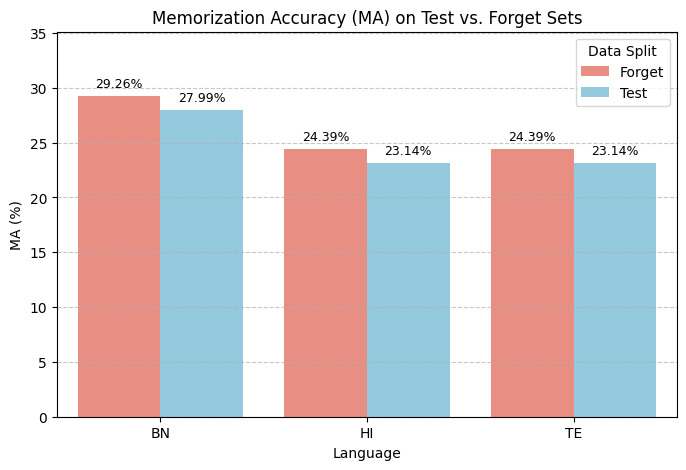

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from google.colab import files

# Define the path to the CSV file
csv_path = ".checkpoints/simplified/flores_metrics.csv"

# --- 1. Load and Reformat Data ---
if not os.path.exists(csv_path):
    print(f"Error: {csv_path} not found. Please ensure the previous execution step completed successfully.")
else:
    df_raw = pd.read_csv(csv_path)

    # Convert the wide table format to a long format for plotting
    data_long = []

    # Iterate through each metric and split
    for col in df_raw.columns:
        # e.g., 'te_test_ppl/dataloader_idx_0'
        parts = col.split('/')
        if 'ppl' in parts[0]:
            metric = 'PPL'
        elif 'ma' in parts[0]:
            metric = 'MA'
        else:
            continue

        # e.g., 'te_test_ppl' -> ['te', 'test', 'ppl']
        lang, split, _ = parts[0].rsplit('_', 2)

        value = df_raw.loc[0, col]

        data_long.append({
            'Language': lang.upper(),
            'Split': split.capitalize(),
            'Metric': metric,
            'Value': value
        })

    df_long = pd.DataFrame(data_long)

    # Pivot for easier analysis
    df_analysis = df_long.pivot_table(index=['Language', 'Split'], columns='Metric', values='Value').reset_index()

    # Convert MA to percentage
    df_analysis['MA_Pct'] = df_analysis['MA'] * 100

    print("\n--- Summary Table (MA in %) ---")
    print(df_analysis.pivot_table(index='Split', columns='Language', values=['PPL', 'MA_Pct']).to_markdown())

    # --- 2. Generate Plot: Memorization Accuracy (MA) ---
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x='Language',
        y='MA_Pct',
        hue='Split',
        data=df_analysis,
        palette={'Test': 'skyblue', 'Forget': 'salmon'}
    )

    plt.title('Memorization Accuracy (MA) on Test vs. Forget Sets')
    plt.ylabel('MA (%)')
    plt.ylim(0, df_analysis['MA_Pct'].max() * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Data Split')

    # Add MA percentage labels on top of the bars
    for container in plt.gca().containers:
        for i, bar in enumerate(container):
            height = bar.get_height()
            plt.gca().text(
                bar.get_x() + bar.get_width() / 2.,
                height + 0.5,
                f'{height:.2f}%',
                ha='center',
                va='bottom',
                fontsize=9
            )

    plt.show()
